Dimensionality Reduction and Clustering of 2-photon Neuron Activity 

This code takes in trial-averaged 2-photon calcium imaging activity across all recorded neurons (matrix dimensions are neuron by sample). The second dimension is samples of time where conditions can be appended together (for example in the oddball paradigm, first third of samples are from standard context, then deviant, then control). The data are first z-scored, then PCA is performed across time to reduce the number of "features", then the silhouette score is used to assess the optimal number of clusters to ask for, then finally the clustering algorithm is run and samples (neurons) are clustered.

Input: *_cluster file output from the script: E:\Dropbox (Frohlich Lab)\Frohlich Lab Team Folder\Codebase\CodeCharles\VAOddball_Analysis\Ca2+\VAOddball_EvtRelatedCaSplice_MK801_V14.m
    This contains the matrix 'data' that contains the neural activity data (matrix dimensions are neuron by sample)

Output: E:/2pdata/GroupLevel/evtRel_toPythonClust/clusteredData/animalNum file that contains each ROI's cluster family ID

2018/12/14 - Zhe Charles Zhou



In [8]:

from __future__ import print_function

import IPython
print('IPython:', IPython.__version__)

import numpy as np
print('numpy:', np.__version__)

import scipy
print('scipy:', scipy.__version__)

import matplotlib
print('matplotlib:', matplotlib.__version__)

import sklearn
print('scikit-learn:', sklearn.__version__)

import seaborn
print('seaborn', seaborn.__version__)

import scipy.io as sio
print('scipy', scipy.__version__)

import h5py
print('h5py', h5py.__version__)

import pandas as pd

import matplotlib.cm as cm

import pylab as plt

IPython: 6.5.0
numpy: 1.15.1
scipy: 1.1.0
matplotlib: 2.2.3
scikit-learn: 0.19.2
seaborn 0.9.0
scipy 1.1.0
h5py 2.8.0


Input matrix should be an n_samples, n_features array.


In [2]:
animalNum = 'All';
mat = scipy.io.loadmat('E:/2pdata/GroupLevel/evtRelated_devStandCtrl/1/allAnimals_cluster')
#mat = scipy.io.loadmat('E:/2pdata/GroupLevel/evtRelated_devStandCtrl/1/session/0148_VisualOddball_201802091_cluster')
#print(mat)

In [3]:
data = mat.get('toPythonClustAll') 
numSamples = len(data)
print( str(numSamples) + ' ROIs')
# print(data)


282 ROIs


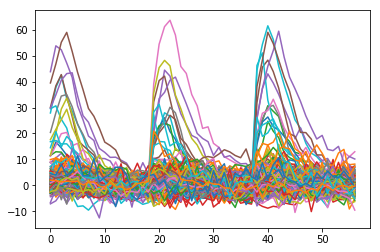

In [9]:
data.shape
plt.plot(data.T)

In [14]:
# z-score the data - important to scale the data for subsequent PCA and clustering

from sklearn.preprocessing import StandardScaler

scaledData = StandardScaler().fit_transform(data) # z-score the data to mean of 0 and std dev of 1
scaledData = data
print( 'Num features/time-samples: ' + str(scaledData.shape[1] ) )

Num features/time-samples: 69


(339, 69)
10


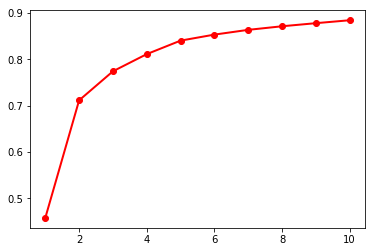

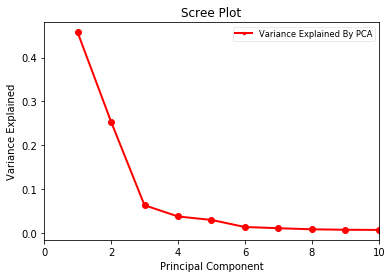

In [15]:
# determine number of PCs to include in clustering based on scree plot
# based on: https://stats.stackexchange.com/questions/12819/how-to-draw-a-scree-plot-in-python

from sklearn.decomposition import PCA
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#Make a random array and then make it positive-definite
num_PC = scaledData.shape[1]
print(scaledData.shape)
num_PC = 10
pca = sklearn.decomposition.PCA(n_components = num_PC)
pcaScree = pca.fit(scaledData)
print(pcaScree.n_components)
xaxis = range(1,pcaScree.n_components_+1)

cumulative_variance = []
cs = 0
for value in pcaScree.explained_variance_ratio_:
    cs = cs + value
    cumulative_variance.append(cs)
    
plt.figure()
plt.plot(xaxis, cumulative_variance, 'ro-', linewidth=2)
plt.figure()
plt.plot(xaxis, pcaScree.explained_variance_ratio_, 'ro-', linewidth=2) 
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xlim((0,num_PC))
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Variance Explained By PCA'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()



In [16]:
# perform PCA 
from sklearn.decomposition import PCA

numPCs = 3

pca = PCA(n_components = numPCs) # USER DEFINE how many PCs to keep
pcaOut = pca.fit_transform(scaledData)

#print(pcaOut)

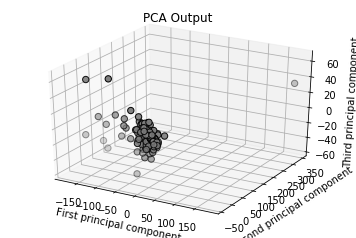

In [17]:
# plot data in PC space
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # allows for 3d plots

if numPCs == 2:
    plt.title('PCA Output')
    plt.scatter(pcaOut[:, 0], pcaOut[:, 1], s=40, c='gray', edgecolors=(0, 0, 0))
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
elif numPCs > 2:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pcaOut[:, 0], pcaOut[:, 1], pcaOut[:, 2], s=40, c='gray', edgecolors=(0, 0, 0))
    ax.set_title('PCA Output')
    ax.set_xlabel('First principal component')
    ax.set_ylabel('Second principal component')
    ax.set_zlabel('Third principal component')



(339, 69)
For n_clusters = 2 The average silhouette_score is : 0.8107829201896983


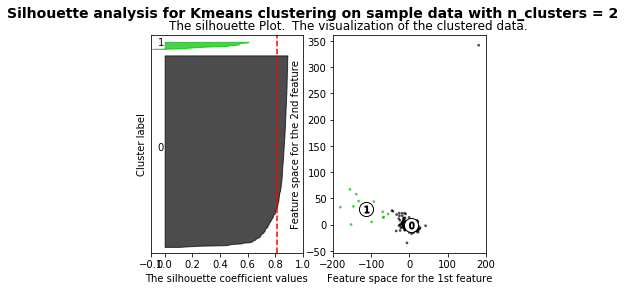

For n_clusters = 3 The average silhouette_score is : 0.8190138486884831


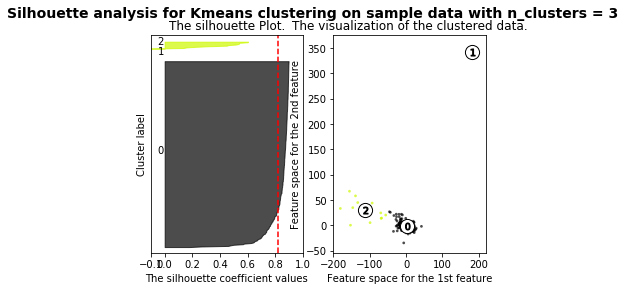

For n_clusters = 4 The average silhouette_score is : 0.5069995922852911


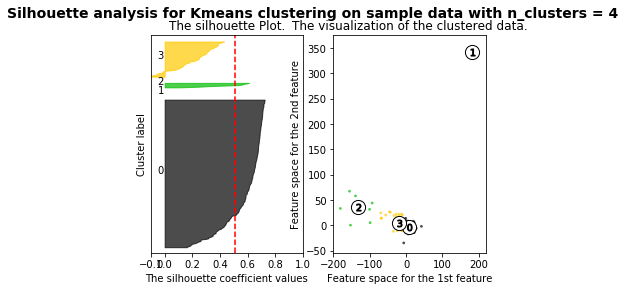

For n_clusters = 5 The average silhouette_score is : 0.44135821416249876


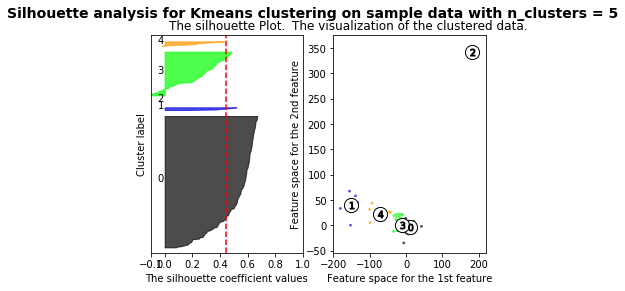

For n_clusters = 6 The average silhouette_score is : 0.44523704221159727


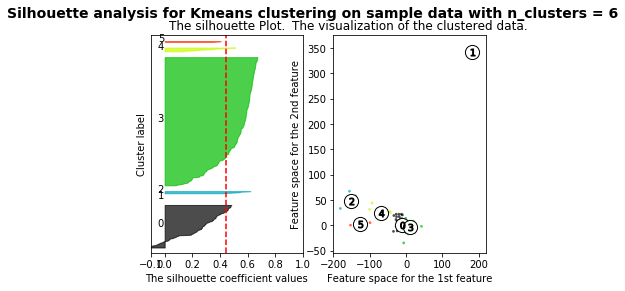

In [18]:
# Using silhouette optimization, determine number of clusters to ask for in spectral clustering
# used this example as template: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

cluster_data = scaledData
print(cluster_data.shape)

clusterMethod = 1; # USER DEFINE: 1 for kmeans, 2 for spectral clustering
if clusterMethod == 1:
    clusterName = 'Kmeans'
elif clusterMethod == 2:
    clusterName = 'Spectral'

from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.pyplot as plt



range_n_clusters = [2,3,4,5,6]
silhAll = [] # initialize matrix to save avg silh scores across cluster analyses

for n_clusters in range_n_clusters: # calculate silh scores and plots for each 
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    #The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pcaOut) + (n_clusters + 1) * 10])
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 0 for reproducibility.
    if clusterMethod == 1: # kmeans
        clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    elif clusterMethod == 2: # spectral cluster
        clusterer = SpectralClustering(n_clusters=n_clusters, 
            assign_labels="kmeans",
            random_state=0, affinity = 'nearest_neighbors', n_neighbors = 7).fit(cluster_data)
    cluster_labels = clusterer.fit_predict(pcaOut)
    
    # The silhouette_score gives the average value for all the samples.
    # want to maximize silh score: mean intra-cluster distance minus the mean nearest-cluster distance
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pcaOut, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    silhAll.append(silhouette_avg) # make list of avg silh values for each cluster number
    
     # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pcaOut, cluster_labels)

    y_lower = 10 # just used to position the text in the plot
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette Plot.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(pcaOut[:, 0], pcaOut[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    if clusterMethod == 1:
        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for " + clusterName + " clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    plt.show()

used these two links to create my code for the spectral clustering: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

In [19]:
from sklearn.cluster import SpectralClustering
import operator # used for determining max value for num clusters

index, value = max(enumerate(silhAll), key=operator.itemgetter(1)) # find which cluster number analysis has highest silh score
numClustFinal = range_n_clusters[index]

print( 'Best Num Clust: ' + str(numClustFinal))

if clusterMethod == 1:
    finalClusterer = KMeans(n_clusters=numClustFinal, random_state=0) # Josh: should perform multiple iterations and choose best
elif clusterMethod == 2:
    finalClusterer = SpectralClustering(n_clusters=numClustFinal,
       assign_labels="kmeans",
       random_state=0).fit(pcaOut)

y_pred = finalClusterer.fit_predict(pcaOut)
  
#y_pred = finalClusterer.labels_.astype(np.int)
#print(y_pred)

# save cluster belonging data 
scipy.io.savemat('E:/2pdata/GroupLevel/evtRel_toPythonClust/clusteredData/' + animalNum, mdict={'y_pred':y_pred})


Best Num Clust: 3


Text(0,0.5,'Second principal component')

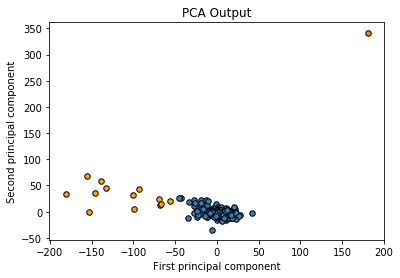

In [10]:
colors = ['#377eb8', '#ff7f00','#ffa500','#191970','#7cfc00']
clustName = ['Clust1','Clust2']

numPCs = 2
if numPCs == 2:

    for iClust in range(numClustFinal): # loop through cluster IDs

        theseROIs = np.where(y_pred == iClust) # find ROIs that belong to this cluster
        plt.scatter( pcaOut[theseROIs, 0], pcaOut[theseROIs, 1], s=30,
                    c=colors[iClust], edgecolors=(0, 0, 0))

elif numPCs > 2:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for iClust in range(numClustFinal): # loop through cluster IDs
        
        theseROIs = np.where(y_pred == iClust) # find ROIs that belong to this cluster

        ax.scatter(pcaOut[theseROIs, 0], pcaOut[theseROIs, 1], pcaOut[theseROIs, 2], s=40, c=colors[iClust], edgecolors=(0, 0, 0))
        ax.set_title('PCA Output')
        ax.set_xlabel('First principal component')
        ax.set_ylabel('Second principal component')
        ax.set_zlabel('Third principal component')
    
plt.title('PCA Output')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')